## 0. Getting setup

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"haastro","key":"10f4ee70eb923e69c2395f457aefcb19"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle|/

/bin/bash: line 1: /: Is a directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#! kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset
! kaggle datasets download -d ananthu017/emotion-detection-fer

 97% 63.0M/65.2M [00:03<00:00, 20.6MB/s]
100% 65.2M/65.2M [00:04<00:00, 17.0MB/s]


Link kaggle dataset <link>https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer</link>

In [ ]:
! unzip emotion-detection-fer.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/im37.png      
  inflating: train/sad/im370.png     
  inflating: train/sad/im3700.png    
  inflating: train/sad/im3701.png    
  inflating: train/sad/im3702.png    
  inflating: train/sad/im3703.png    
  inflating: train/sad/im3704.png    
  inflating: train/sad/im3705.png    
  inflating: train/sad/im3706.png    
  inflating: train/sad/im3707.png    
  inflating: train/sad/im3708.png    
  inflating: train/sad/im3709.png    
  inflating: train/sad/im371.png     
  inflating: train/sad/im3710.png    
  inflating: train/sad/im3711.png    
  inflating: train/sad/im3712.png    
  inflating: train/sad/im3713.png    
  inflating: train/sad/im3714.png    
  inflating: train/sad/im3715.png    
  inflating: train/sad/im3716.png    
  inflating: train/sad/im3717.png    
  inflating: train/sad/im3718.png    
  inflating: train/sad/im3719.png    
  inflating: train/sad/im372.png     
  inflating: train/sad/im3720.png    

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

In [ ]:
# Download pizza, steak, sushi images from GitHub
from pathlib import Path
image_path = Path("images")

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

In [ ]:
#!pip install --ignore-installed --upgrade tensorflow==2.4.1 --user

In [ ]:
import time
import numpy as np
import os
import pydot
from typing import List, Tuple
from matplotlib.pyplot import imshow
%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image
import pathlib
import shutil

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model

from tensorflow.python.keras.utils import layer_utils
#from tensorflow.keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.imagenet_utils import preprocess_input

from IPython.display import SVG

import scipy.misc

import tensorflow.keras.backend as K
K.set_image_data_format('channels_last') # can be channels_first or channels_last.
K.set_learning_phase(1) # 1 stands for learning phase

# ResNet building blocks

In [ ]:
def identity_block(X: tf.Tensor, level: int, block: int, filters: List[int]) -> tf.Tensor:
    # layers will be called conv{level}_iden{block}_{convlayer_number_within_block}'
    conv_name = f'conv{level}_{block}' + '_{layer}_{type}'

    # unpack number of filters to be used for each conv layer
    f1, f2, f3 = filters

    # the shortcut branch of the identity block
    # takes the value of the block input
    X_shortcut = X

    # first convolutional layer (plus batch norm & relu activation, of course)
    X = Conv2D(filters=f1, kernel_size=(1, 1), strides=(1, 1),
               padding='valid', name=conv_name.format(layer=1, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=1, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=1, type='relu'))(X)

    # second convolutional layer
    X = Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1),
               padding='same', name=conv_name.format(layer=2, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=2, type='bn'))(X)
    X = Activation('relu')(X)

    # third convolutional layer
    X = Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1),
               padding='valid', name=conv_name.format(layer=3, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=3, type='bn'))(X)

    # add shortcut branch to main path
    X = Add()([X, X_shortcut])

    # relu activation at the end of the block
    X = Activation('relu', name=conv_name.format(layer=3, type='relu'))(X)

    return X

In [ ]:
def convolutional_block(X: tf.Tensor, level: int, block: int, filters: List[int], s: Tuple[int,int,int]=(2, 2)) -> tf.Tensor:

    # layers will be called conv{level}_{block}_{convlayer_number_within_block}'
    conv_name = f'conv{level}_{block}' + '_{layer}_{type}'

    # unpack number of filters to be used for each conv layer
    f1, f2, f3 = filters

    # the shortcut branch of the convolutional block
    X_shortcut = X

    # first convolutional layer
    X = Conv2D(filters=f1, kernel_size=(1, 1), strides=s, padding='valid',
               name=conv_name.format(layer=1, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=1, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=1, type='relu'))(X)

    # second convolutional layer
    X = Conv2D(filters=f2, kernel_size=(3, 3), strides=(1, 1), padding='same',
               name=conv_name.format(layer=2, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=2, type='bn'))(X)
    X = Activation('relu', name=conv_name.format(layer=2, type='relu'))(X)

    # third convolutional layer
    X = Conv2D(filters=f3, kernel_size=(1, 1), strides=(1, 1), padding='valid',
               name=conv_name.format(layer=3, type='conv'),
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=conv_name.format(layer=3, type='bn'))(X)

    # shortcut path
    X_shortcut = Conv2D(filters=f3, kernel_size=(1, 1), strides=s, padding='valid',
                        name=conv_name.format(layer='short', type='conv'),
                        kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=conv_name.format(layer='short', type='bn'))(X_shortcut)

    # add shortcut branch to main path
    X = Add()([X, X_shortcut])

    # nonlinearity
    X = Activation('relu', name=conv_name.format(layer=3, type='relu'))(X)

    return X

# 4. Defining the ResNet model

In [ ]:
def ResNet50(input_size: Tuple[int,int,int], classes: int) -> Model:

    # tensor placeholder for the model's input
    X_input = Input(input_size)

    ### Level 1 ###

    # padding
    X = ZeroPadding2D((3, 3))(X_input)

    # convolutional layer, followed by batch normalization and relu activation
    X = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2),
               name='conv1_1_1_conv',
               kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='conv1_1_1_nb')(X)
    X = Activation('relu')(X)

    ### Level 2 ###

    # max pooling layer to halve the size coming from the previous layer
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # 1x convolutional block
    X = convolutional_block(X, level=2, block=1, filters=[64, 64, 256], s=(1, 1))

    # 2x identity blocks
    X = identity_block(X, level=2, block=2, filters=[64, 64, 256])
    X = identity_block(X, level=2, block=3, filters=[64, 64, 256])

    ### Level 3 ###

    # 1x convolutional block
    X = convolutional_block(X, level=3, block=1, filters=[128, 128, 512], s=(2, 2))

    # 3x identity blocks
    X = identity_block(X, level=3, block=2, filters=[128, 128, 512])
    X = identity_block(X, level=3, block=3, filters=[128, 128, 512])
    X = identity_block(X, level=3, block=4, filters=[128, 128, 512])

    ### Level 4 ###
    # 1x convolutional block
    X = convolutional_block(X, level=4, block=1, filters=[256, 256, 1024], s=(2, 2))
    # 5x identity blocks
    X = identity_block(X, level=4, block=2, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=3, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=4, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=5, filters=[256, 256, 1024])
    X = identity_block(X, level=4, block=6, filters=[256, 256, 1024])

    ### Level 5 ###
    # 1x convolutional block
    X = convolutional_block(X, level=5, block=1, filters=[512, 512, 2048], s=(2, 2))
    # 2x identity blocks
    X = identity_block(X, level=5, block=2, filters=[512, 512, 2048])
    X = identity_block(X, level=5, block=3, filters=[512, 512, 2048])

    # Pooling layers
    X = AveragePooling2D(pool_size=(2, 2), name='avg_pool')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc_' + str(classes),
              kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [ ]:
model = ResNet50(input_size = (image_size[1], image_size[0], channels), classes = num_classes)
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def square_crop_image(im: PIL.Image) -> PIL.Image:
    width, height = im.size
    new_size = min(width, height)

    # center crop
    left = (width - new_size) / 2
    top = (height - new_size) / 2
    right = (width + new_size) / 2
    bottom = (height + new_size) / 2

    crop_im = im.crop((left, top, right, bottom))
    crop_im = crop_im.convert('RGB')

    return crop_im

In [ ]:
def make_dataset(in_folder, im_per_class):
    # iterate through all folders (there should be one folder per object class)
    for fld in os.listdir(in_folder):
        # create the output folder for processed images for current class
        # delete folder and contents if there is one already
        out = os.path.join(out_folder, fld)
        if os.path.exists(out):
            shutil.rmtree(out)
        os.makedirs(out)

        fld_path = pathlib.Path(os.path.join(in_folder, fld))
        num_images = 0
        for file in list(fld_path.glob('*')):
            # open image, center crop to a square
            # save to the output folder
            with PIL.Image.open(file) as im:
                crop_im = square_crop_image(im)
                crop_im.save(os.path.join(out, str(num_images) + '.jpg'))
                im.close()
            # break when desired number of images
            # has been processed (to keep classes balance)
            num_images = num_images + 1
            if (num_images > im_per_class):
                break

# Load data

In [ ]:
# set input image parameters
image_size = (64, 64)
channels = 3
num_classes = 7

In [ ]:
img_height = image_size[1]
img_width = image_size[0]
batch_size = 32

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/train',
    validation_split=0.1,  # Set validation_split to None
    subset="training",
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/test",
    validation_split=0.6,
    subset="validation",
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 28709 files belonging to 7 classes.
Using 25839 files for training.
Found 7178 files belonging to 7 classes.
Using 4306 files for validation.


In [ ]:
class_names = val_ds.class_names
print(class_names)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [ ]:
rm -rf /content/test/emotion/.ipynb_checkpoints

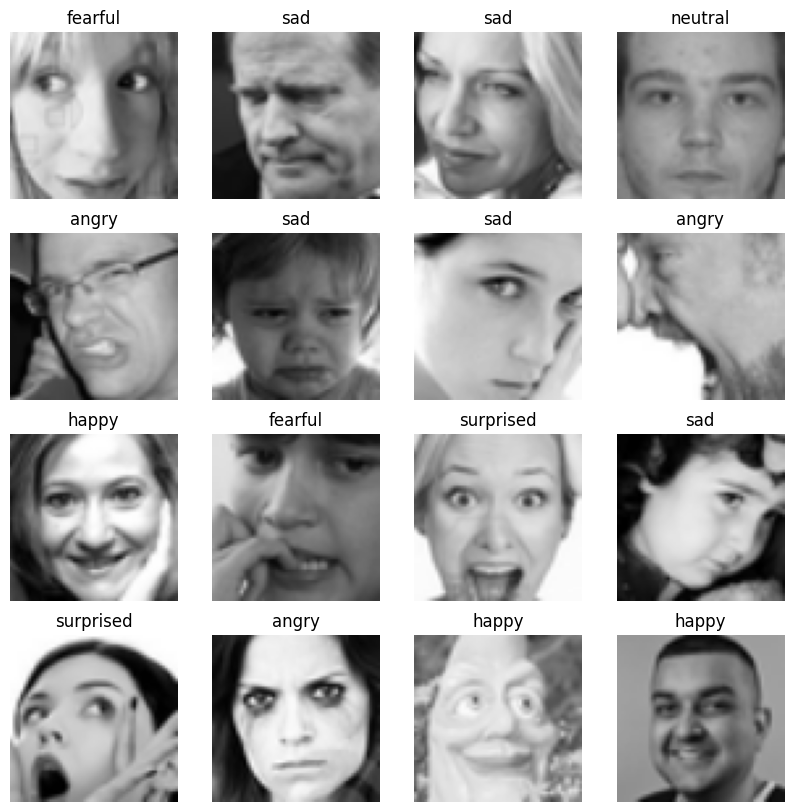

In [ ]:
plt.figure(figsize=(10, 10))

i = 1

for images, labels in train_ds.take(1):
    for (image, label) in zip(images, labels):
        ax = plt.subplot(4, 4, i)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(label, axis=0)])
        plt.axis("off")
        i = i + 1
        if i == 17:
            break
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import Rescaling


# Use Keras functionality for adding a rescaling layer
normalization_layer = layers.Rescaling(1.0 / 255)

# Rescale training and validation sets
norm_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
norm_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


In [ ]:

image_batch, labels_batch = next(iter(norm_train_ds))

# get one image
first_image = image_batch[0]

# confirm pixel values are now in the [0,1] range
print(np.min(first_image), np.max(first_image))

0.009007353 0.960478


# Training

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

norm_train_ds = norm_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
norm_val_ds = norm_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from keras.callbacks import ModelCheckpoint
model_path = 'cv_model_2.h5'
callbacks = [
    ModelCheckpoint(model_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=0)
]

In [ ]:
import time
import matplotlib.pyplot as plt

# Compile model trước khi training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start = time.time()

history = model.fit(
    train_ds,
    batch_size=1024,
    validation_data=val_ds,
    epochs=40,
    callbacks=callbacks,
)

stop = time.time()

print(history.history.keys())

plt.figure(figsize=(12, 10))

# summarize history for accuracy
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# summarize history for loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


Epoch 1/40
808/808 [==============================] - 104s 66ms/step - loss: 2.1526 - accuracy: 0.2324 - val_loss: 1.9355 - val_accuracy: 0.1735
Epoch 2/40
808/808 [==============================] - 49s 61ms/step - loss: 1.8270 - accuracy: 0.2999 - val_loss: 1.9482 - val_accuracy: 0.3182
Epoch 3/40
808/808 [==============================] - 49s 60ms/step - loss: 1.7330 - accuracy: 0.3573 - val_loss: 2.6795 - val_accuracy: 0.3430
Epoch 4/40
808/808 [==============================] - 48s 59ms/step - loss: 1.6715 - accuracy: 0.3915 - val_loss: 4.8383 - val_accuracy: 0.3158
Epoch 5/40
808/808 [==============================] - 53s 65ms/step - loss: 1.6845 - accuracy: 0.3631 - val_loss: 1.6111 - val_accuracy: 0.3581
Epoch 6/40
808/808 [==============================] - 48s 59ms/step - loss: 1.6500 - accuracy: 0.3847 - val_loss: 1.8857 - val_accuracy: 0.3158
Epoch 7/40
808/808 [==============================] - 49s 60ms/step - loss: 1.4691 - accuracy: 0.4428 - val_loss: 40.7686 - val_accurac

In [ ]:
from keras.models import load_model


old_model = load_model("/content/drive/MyDrive/cv_model_1.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with tf.device('/gpu:0'):
    history = old_model.fit(
        norm_train_ds,
        validation_data=norm_val_ds,
        epochs=40,

        callbacks=callbacks,
    )

Epoch 1/40
900/900 [==============================] - 54s 60ms/step - loss: 0.0500 - accuracy: 0.9841 - val_loss: 3.4760 - val_accuracy: 0.5568
Epoch 2/40
900/900 [==============================] - 53s 59ms/step - loss: 0.0239 - accuracy: 0.9924 - val_loss: 4.0076 - val_accuracy: 0.5152
Epoch 3/40
900/900 [==============================] - 54s 60ms/step - loss: 0.0515 - accuracy: 0.9843 - val_loss: 3.8751 - val_accuracy: 0.4778
Epoch 4/40
900/900 [==============================] - 52s 58ms/step - loss: 0.0378 - accuracy: 0.9876 - val_loss: 3.6702 - val_accuracy: 0.5261
Epoch 5/40
900/900 [==============================] - 50s 56ms/step - loss: 0.0453 - accuracy: 0.9853 - val_loss: 3.8987 - val_accuracy: 0.5313
Epoch 6/40
900/900 [==============================] - 50s 56ms/step - loss: 0.0362 - accuracy: 0.9878 - val_loss: 3.7537 - val_accuracy: 0.4918
Epoch 7/40
900/900 [==============================] - 51s 57ms/step - loss: 0.0211 - accuracy: 0.9935 - val_loss: 3.8212 - val_accuracy:

In [ ]:
pred = old_model.predict(norm_train_ds)


900/900 [==============================] - 12s 12ms/step


In [ ]:
y_pred = np.argmax(pred, axis=1)
y_pred

array([5, 2, 5, ..., 6, 2, 3])

# CNN model and Image Data generator

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
img_size = 48

In [ ]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(directory = '/content/train',
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = '/content/test',
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "rgb",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [ ]:
import os
from collections import defaultdict

# Tạo danh sách thư mục con và số lượng file tương ứng
subdirectory_counts = defaultdict(int)

# Lặp qua tất cả các file trong thư mục train
for root, _, files in os.walk('/content/train'):
    for file in files:
        # Lấy tên thư mục con
        subdirectory = os.path.basename(root)
        # Tăng số lượng file của thư mục con đó lên 1
        subdirectory_counts[subdirectory] += 1

# In kết quả thống kê
for subdirectory, count in subdirectory_counts.items():
    print(f"{subdirectory}: {count} files")


angry: 3995 files
surprised: 3171 files
neutral: 4965 files
happy: 7215 files
fearful: 4097 files
sad: 4830 files
disgusted: 436 files


In [ ]:
import os
from collections import defaultdict

# Tạo danh sách nhãn và số lượng mẫu tương ứng
label_counts = defaultdict(int)

# Lặp qua tất cả các thư mục con trong '/content/train'
for subdirectory in os.listdir('/content/test'):
    # Kiểm tra xem subdirectory có phải là thư mục không
    if os.path.isdir(os.path.join('/content/test', subdirectory)):
        # Đếm số lượng mẫu trong thư mục con và tăng số lượng nhãn tương ứng
        count = len(os.listdir(os.path.join('/content/test', subdirectory)))
        label_counts[subdirectory] += count

# In kết quả thống kê
for label, count in label_counts.items():
    print(f"{label}: {count} samples")


angry: 958 samples
surprised: 831 samples
neutral: 1233 samples
happy: 1774 samples
fearful: 1024 samples
sad: 1247 samples
disgusted: 111 samples


In [ ]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(lr=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

In [ ]:
epochs = 60
batch_size = 64

In [ ]:
history = model.fit(x = train_generator,epochs = 60,validation_data = validation_generator)

# Save the trained model
model.save('emotion_classification_xception.h5')

Epoch 1/60


InternalError: ignored

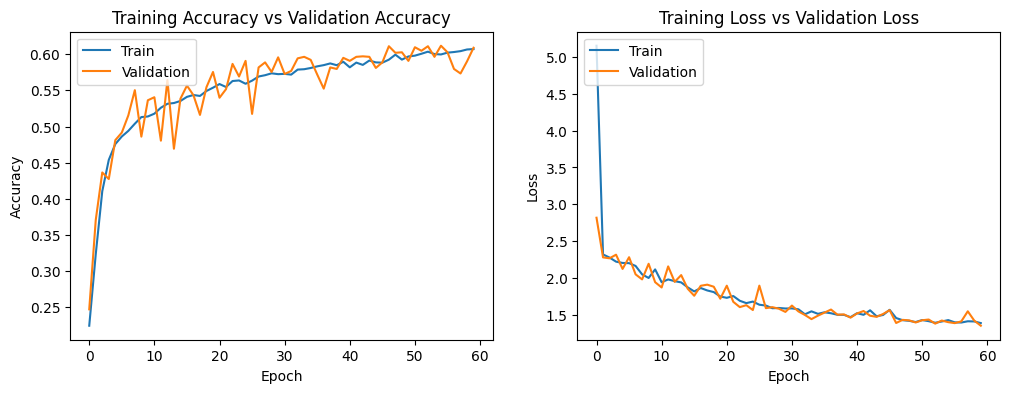

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

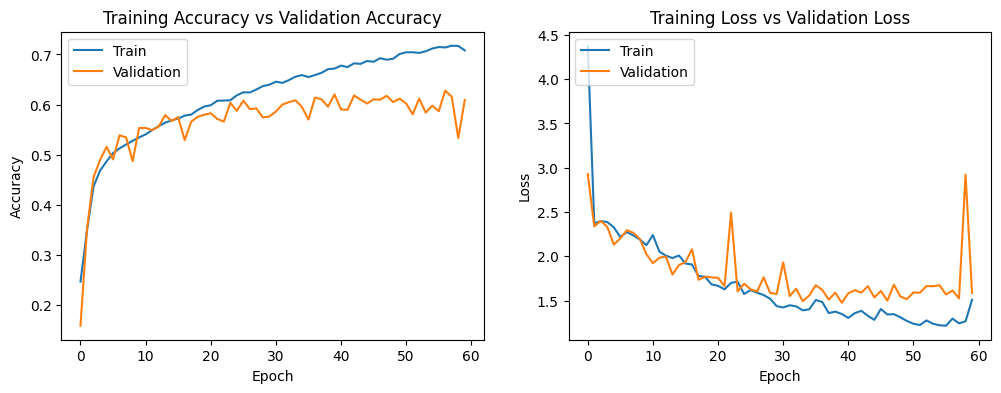

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
model.save('model_optimal.h5')

# Xception

In [ ]:
# set input image parameters
image_size = (64, 64)
channels = 3
num_classes = 7

In [ ]:
img_height = image_size[1]
img_width = image_size[0]
batch_size = 32

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the Xception model without the top (fully connected) layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(71, 71,3))

# Add your own fully connected layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(512, activation='relu')(x)
'''
model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))
'''
predictions = Dense(num_classes, activation='softmax')(x)  # num_classes represents the number of emotions

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model's layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation and preprocessing
'''
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='categorical')
'''
# Train the model
history = model.fit(x = train_generator,epochs = 60,validation_data = validation_generator)

# Save the trained model
model.save('emotion_classification_xception.h5')


83683744/83683744 [==============================] - 1s 0us/step
Epoch 1/60
278/359 [======================>.......] - ETA: 7s - loss: 1.6997 - accuracy: 0.3217

KeyboardInterrupt: ignored

In [ ]:
history = model.fit(x = train_generator,epochs = 60,validation_data = validation_generator)
model.save('emotion_classification_xception.h5')

Epoch 1/60
359/359 [==============================] - 32s 90ms/step - loss: 1.1992 - accuracy: 0.5460 - val_loss: 1.5618 - val_accuracy: 0.4452
Epoch 2/60
359/359 [==============================] - 31s 87ms/step - loss: 1.1914 - accuracy: 0.5523 - val_loss: 1.5444 - val_accuracy: 0.4500
Epoch 3/60
359/359 [==============================] - 32s 90ms/step - loss: 1.1950 - accuracy: 0.5495 - val_loss: 1.5481 - val_accuracy: 0.4505
Epoch 4/60
359/359 [==============================] - 31s 87ms/step - loss: 1.1886 - accuracy: 0.5504 - val_loss: 1.5458 - val_accuracy: 0.4366
Epoch 5/60
359/359 [==============================] - 32s 90ms/step - loss: 1.1882 - accuracy: 0.5548 - val_loss: 1.5589 - val_accuracy: 0.4483
Epoch 6/60
359/359 [==============================] - 32s 90ms/step - loss: 1.1797 - accuracy: 0.5546 - val_loss: 1.5524 - val_accuracy: 0.4477
Epoch 7/60
359/359 [==============================] - 32s 90ms/step - loss: 1.1833 - accuracy: 0.5522 - val_loss: 1.5790 - val_accuracy:

# mini-xception

In [ ]:
import pandas as pd
import cv2
import numpy as np

from sklearn.model_selection import train_test_split

In [ ]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.layers import Activation, Convolution2D, Conv2D, Dropout, AveragePooling2D, BatchNormalization, GlobalAveragePooling2D, Flatten, Input, MaxPooling2D, SeparableConv2D
from keras.models import Model
from keras.regularizers import l2

In [ ]:
batch_size = 32
epochs = 100
image_shape = (48, 48, 3)
verbose = True
num_class = 7
patience = 50  # number of epochs with no improvement after which training will be stopped
base_path = './'
l2_regularization = 0.01

In [ ]:
data_generator = ImageDataGenerator(featurewise_center=False, featurewise_std_normalization=False, rotation_range=10,
                                    width_shift_range=0.1, height_shift_range=0.1, zoom_range=.1, horizontal_flip=True)


In [ ]:
regularization = l2(l2_regularization)

In [ ]:
image_input = Input(image_shape)
x = Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), kernel_regularizer=regularization, use_bias=False)(image_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# module 1
# residual module
residual = Conv2D(filters=16, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

x = SeparableConv2D(filters=16, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=16, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])

# module 2
# residual module
residual = Conv2D(filters=32, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

x = SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=32, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])

# module 3
# residual module
residual = Conv2D(filters=64, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

x = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=64, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])

# module 4
# residual module
residual = Conv2D(filters=128, kernel_size=(1,1), strides=(2,2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)

x = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(filters=128, kernel_size=(3,3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
x = layers.add([x,residual])

x = Conv2D(filters=num_class, kernel_size=(3,3), padding='same')(x)
x = GlobalAveragePooling2D()(x)

output = Activation('softmax', name='predictions')(x)

In [ ]:
model = Model(image_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 46, 46, 8)    216         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 46, 46, 8)   32          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 46, 46, 8)    0           ['batch_normalization[0][0]']

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=int(patience/4), verbose=verbose)

trained_models_path = base_path + '_mini_xception'
model_names = trained_models_path + 'model.hdf5'
model_checkpoint = ModelCheckpoint(filepath=model_names, monitor='val_accuracy', verbose=verbose, save_best_only=True)

callbacks = [model_checkpoint,  early_stop, reduce_lr]

In [ ]:
history = model.fit(
        train_generator,
        batch_size=64,
        validation_data=validation_generator,
        epochs=60,
        callbacks=callbacks,
)

Epoch 1/60
359/359 [==============================] - ETA: 0s - loss: 1.8284 - accuracy: 0.3177
Epoch 1: val_loss improved from inf to 1.91590, saving model to ./_mini_xceptionmodel.hdf5
359/359 [==============================] - 53s 89ms/step - loss: 1.8284 - accuracy: 0.3177 - val_loss: 1.9159 - val_accuracy: 0.2242 - lr: 0.0010
Epoch 2/60
359/359 [==============================] - ETA: 0s - loss: 1.5748 - accuracy: 0.4200
Epoch 2: val_loss improved from 1.91590 to 1.57731, saving model to ./_mini_xceptionmodel.hdf5
359/359 [==============================] - 31s 86ms/step - loss: 1.5748 - accuracy: 0.4200 - val_loss: 1.5773 - val_accuracy: 0.4413 - lr: 0.0010
Epoch 3/60
359/359 [==============================] - ETA: 0s - loss: 1.4540 - accuracy: 0.4658
Epoch 3: val_loss improved from 1.57731 to 1.42634, saving model to ./_mini_xceptionmodel.hdf5
359/359 [==============================] - 30s 84ms/step - loss: 1.4540 - accuracy: 0.4658 - val_loss: 1.4263 - val_accuracy: 0.4881 - lr: 

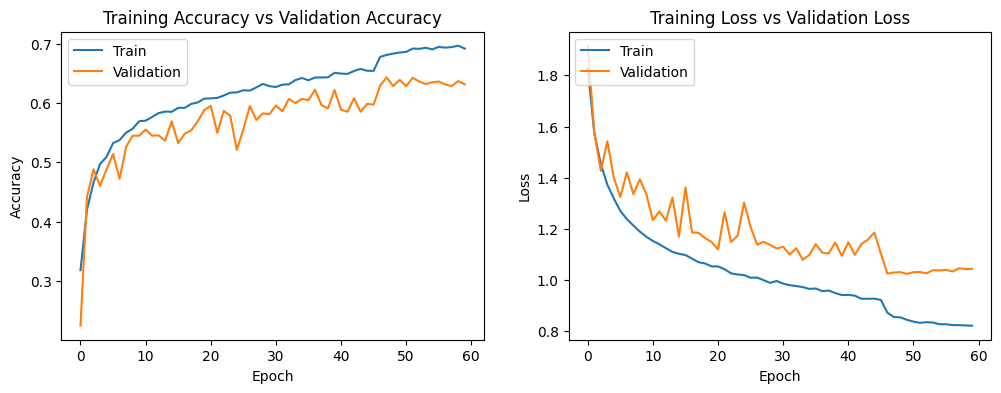

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

23/23 [==============================] - 1s 33ms/step


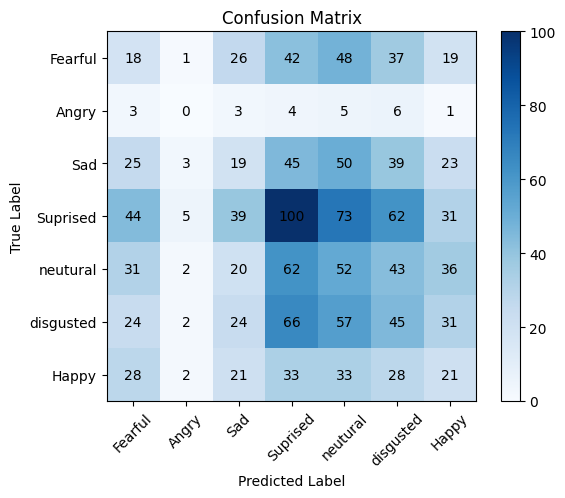

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Generate predictions for the validation data
validation_steps = len(validation_generator)
y_pred = model.predict(validation_generator, steps=validation_steps)
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Get true labels for the validation data
y_true = validation_generator.classes

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = ['Fearful', 'Angry', 'Sad', 'Suprised', 'neutural', 'disgusted', 'Happy']

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels to each cell
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, cm[i, j], horizontalalignment='center', verticalalignment='center')

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# VGG16

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers[:-4]:
    layer.trainable=False

In [ ]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [ ]:

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

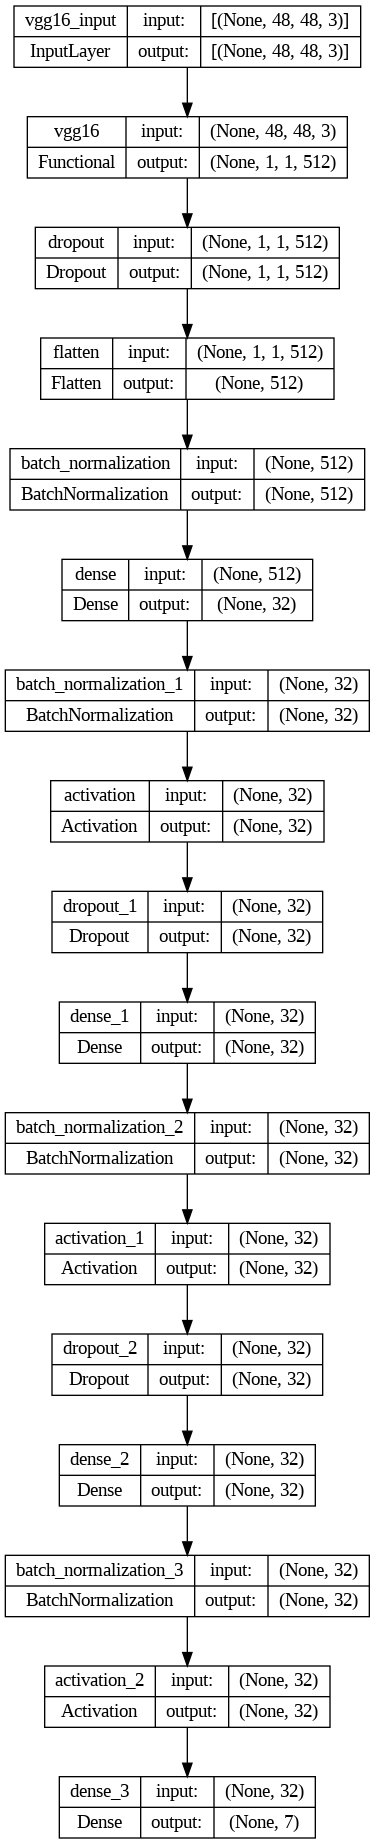

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')


In [ ]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)


In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)


In [ ]:
history = model.fit(
        train_generator,
        batch_size=64,
        validation_data=validation_generator,
        epochs=20,
        callbacks=[lrd,mcp,es],
)

Epoch 1/60
359/359 [==============================] - 51s 101ms/step - loss: 1.9065 - accuracy: 0.8552 - precision: 0.2305 - recall: 0.0059 - auc: 0.6114 - f1_score: 0.0112 - val_loss: 1.8157 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6512 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/60
359/359 [==============================] - 36s 101ms/step - loss: 1.8072 - accuracy: 0.8571 - precision: 0.4864 - recall: 0.0047 - auc: 0.6564 - f1_score: 0.0091 - val_loss: 1.7196 - val_accuracy: 0.8586 - val_precision: 0.8261 - val_recall: 0.0133 - val_auc: 0.7112 - val_f1_score: 0.0269 - lr: 0.0010
Epoch 3/60
359/359 [==============================] - 34s 96ms/step - loss: 1.7305 - accuracy: 0.8583 - precision: 0.6019 - recall: 0.0246 - auc: 0.7004 - f1_score: 0.0469 - val_loss: 1.6731 - val_accuracy: 0.8599 - val_precision: 0.8889 - val_recall: 0.0223 - val_auc: 0.7291 - val_f1_score: 0.0440 - lr: 0.0010
Epoch 4/60
359/359 [===========================

KeyboardInterrupt: ignored

23/23 [==============================] - 1s 44ms/step


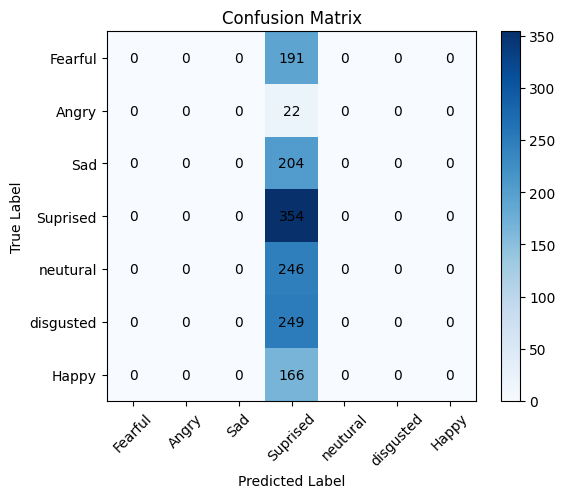

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Generate predictions for the validation data
validation_steps = len(validation_generator)
y_pred = model.predict(validation_generator, steps=validation_steps)
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Get true labels for the validation data
y_true = validation_generator.classes

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = ['Fearful', 'Angry', 'Sad', 'Suprised', 'neutural', 'disgusted', 'Happy']

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels to each cell
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, cm[i, j], horizontalalignment='center', verticalalignment='center')

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
